In [1]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [2]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import pandas as pd
import seaborn as sn
import tensorflow as tf
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [3]:
IMAGE_SIZE = [224, 224]

train_path = 'dataset/train'
valid_path = 'dataset/validation'
test_path = 'dataset/test'

In [4]:
inception = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [5]:
for layer in inception.layers:
    layer.trainable = False

In [6]:
folders = glob('dataset/train/*')

In [7]:
x = Flatten()(inception.output)
x = Dense(1024,activation='relu')(x)

In [8]:
prediction = Dense(len(folders), activation='softmax')(x)
model = Model(inputs=inception.input, outputs=prediction)

In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [10]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dataset = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

valid_dataset = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_dataset = ImageDataGenerator(rescale = 1./255)

In [13]:
training_set = train_dataset.flow_from_directory('dataset/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

validation_set = valid_dataset.flow_from_directory('dataset/validation',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

test_set = test_dataset.flow_from_directory('dataset/test',
                                            target_size = (224, 224),
                                            batch_size = 1,
                                            class_mode = 'categorical')

Found 1960 images belonging to 8 classes.
Found 640 images belonging to 8 classes.
Found 640 images belonging to 8 classes.


In [14]:
r = model.fit(
  training_set,
  validation_data=validation_set,
  epochs=15,
  steps_per_epoch=len(training_set),
  validation_steps=len(validation_set)
)

Epoch 1/15
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
62/62 [==============================] - ETA: 0s - loss: 9.9734 - accuracy: 0.7903 WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x0000020B7C1276A8> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`)

In [15]:
from tensorflow.keras.models import load_model
model.save('model_inception.h5')

In [16]:
test_loss,test_acc = model.evaluate(test_set, verbose=1)
print('\nTest accuracy:', test_acc)

640/640 [==============================] - 88s 136ms/step - loss: 0.2380 - accuracy: 0.9797

Test accuracy: 0.979687511920929


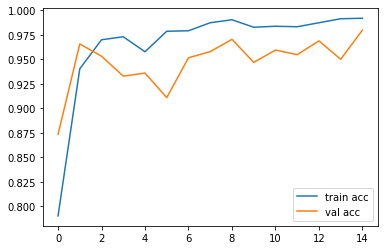

<Figure size 432x288 with 0 Axes>

In [17]:
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

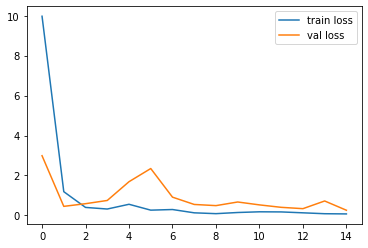

<Figure size 432x288 with 0 Axes>

In [18]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend() 
plt.show()
plt.savefig('LossVal_loss')

In [19]:
nb_samples = len(test_set)
print(nb_samples)

640


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


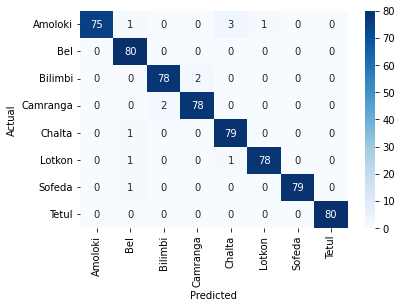

test accuracy : 97.96875


In [20]:
model = tf.keras.models.load_model("model_inception.h5")
filenames = test_set.filenames
#nb_samples = len(test_set)
y_prob=[]
y_act=[]
test_set.reset()
for _ in range(nb_samples):
  X_test,Y_test = test_set.next()
  y_prob.append(model.predict(X_test))
  y_act.append(Y_test)

predicted_class = [list(training_set.class_indices.keys())[i.argmax()] for i in y_prob]
actual_class = [list(training_set.class_indices.keys())[i.argmax()] for i in y_act]


out_df = pd.DataFrame(np.vstack([predicted_class,actual_class]).T,columns=['predicted_class','actual_class'])
confusion_matrix = pd.crosstab(out_df['actual_class'],out_df['predicted_class'], rownames=['Actual'], colnames=['Predicted'])

sn.heatmap(confusion_matrix,cmap='Blues', annot=True,fmt='d')
plt.show()
print('test accuracy : {}'.format((np.diagonal(confusion_matrix).sum()/confusion_matrix.sum().sum()*100)))